## Importing Stock Data

In [1]:
import pandas as pd
import requests
import yfinance as yf
import os
from datetime import datetime
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

## How to pull in CUSIP to ticker mapping (NEEDS AUTOMATED)

In [2]:
## Alpha Vantage API Key
## WHB506UEK5KP34ZA

stan = pd.read_csv(r"Holdings_shares\Stanley_Druckenmiller.csv")

mapping1 = pd.read_csv(r"C:\Users\bfass\OneDrive\Desktop\Fin tools\BigMoney13F\Final_cusip_map\CUSIP_Mapping.csv", usecols = ["CUSIP", "SYMBOL"])
mapping2 = pd.read_csv(r"C:\Users\bfass\OneDrive\Desktop\Fin tools\BigMoney13F\Final_cusip_map\CUSIP_Mapping-Brocks-Laptop.csv", usecols = ["CUSIP", "SYMBOL"])


mapping = pd.concat([mapping1, mapping2]).drop_duplicates()

In [3]:
directory = "Holdings_shares"

# Create an empty dictionary to store DataFrames
dfs = {}

# Iterate through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        # Construct the full file path
        filepath = os.path.join(directory, filename)
        
        # Read the CSV file into a DataFrame
        df_name = os.path.splitext(filename)[0]  # Get the file name without the extension

        read_df = pd.read_csv(filepath)
        read_df = read_df.merge(mapping[["CUSIP", "SYMBOL"]].drop_duplicates(), how = 'left', on = "CUSIP")

        dfs[df_name] = read_df


## Uniue symbols used to pull sector
symbols = pd.concat(dfs.values())

symbols.loc[symbols['SYMBOL'] == 'BRKB', 'SYMBOL'] = 'BRK-B'

symbols = symbols[symbols["SYMBOL"] != 'XELA']

unique_symbols = symbols[["NAME OF ISSUER", "SYMBOL"]].drop_duplicates()

In [4]:
unique_symbols = unique_symbols[~unique_symbols["SYMBOL"].isnull()]

sectors = []
industries = []

for ticker in unique_symbols["SYMBOL"]:
    #print(ticker)
    data = yf.Ticker(ticker)
    try:
        if data.info["quoteType"] == "ETF":
            try:
                sector = data.info['category']  # Attempt to access sector
            except KeyError:
                sector = "Unknown"  # Assign "Unknown" if sector is missing 

            industry = "ETF"
        else:
            try:
                sector = data.info['sector']  # Attempt to access sector
            except KeyError:
                sector = "Unknown"  # Assign "Unknown" if sector is missing

            try:
                industry = data.info["industry"]  # Attempt to access industry
            except KeyError:
                industry = "Unknown"  # Assign "Unknown" if industry is missing
    except:
        sector = "Unknown" 
        industry = "Unknown"


    sectors.append(sector)
    industries.append(industry)

unique_symbols["Sector"] = sectors
unique_symbols["Industry"] = industries


bold_colors = [
    'Consumer Cyclical',
    'Real Estate',
    'Industrials',
    'Communication Services',
    'Financial Services',
    'Healthcare',
    'Consumer Defensive',
    'Basic Materials',
    'Technology',
    'Utilities',
    'Energy'
]

international_related = [
    'China Region',
    'Latin America Stock',
    'Japan Stock',
    'India Equity',
    'Miscellaneous Region',
    'Diversified Emerging Mkts'
]

unique_symbols["Sector_Simp"] = np.where((unique_symbols["Sector"].isin(bold_colors)) | (unique_symbols["Sector"].isin(international_related)), unique_symbols["Sector"],
                                         np.where(unique_symbols["Sector"] == "Financial", "Financial Services",
                                                  np.where(unique_symbols["Sector"] == 'Health', 'Healthcare',
                                                        np.where(unique_symbols["Sector"] == 'Health', 'Healthcare',  
                                                                 np.where(unique_symbols["Sector"] == 'Equity Energy', 'Energy',
                                                                          np.where(unique_symbols["Sector"].isin(['Small Growth', 'Small Blend']), 'Small Caps', "Other ETFs, Bonds or Commodities"))))))

404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/GOOGLZZZZ?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=GOOGLZZZZ&crumb=KgRSRNWII%2F9
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/GOOGLZZZZ?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=GOOGLZZZZ&crumb=KgRSRNWII%2F9
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/GOOGLZZZZ?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=GOOGLZZZZ&crumb=KgRSRNWII%2F9
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/GOOGLZZZZ?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfil

In [ ]:
# Define start and end dates
start_date = "2013-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')

# Create a list to store the downloaded dataframes
historical_data = []

for symbol in unique_symbols["SYMBOL"]:
    # Download historical data for the current symbol
    ticker_data = yf.download(symbol, start=start_date, end=end_date)

    # Append the data to the list
    historical_data.append(ticker_data)

# Optionally, concatenate the dataframes into a single DataFrame with a multi-index
historical_data = pd.concat(historical_data, keys=unique_symbols["SYMBOL"], names=["SYMBOL"]).reset_index()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['VRX']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2013-01-01 -> 2024-09-26)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******************

In [ ]:
holdings_data = {}

for key, df in dfs.items():
    test = df.merge(unique_symbols[['SYMBOL', 'Sector', 'Industry', "Sector_Simp"]], on = "SYMBOL", how = 'left')
    
    test.drop(columns = "Unnamed: 0", inplace = True)

    test = test.melt(id_vars=['NAME OF ISSUER', 'CUSIP', 'CALL', 'SYMBOL','Sector', 'Industry', "Sector_Simp"], var_name='Date', value_name='Shares').drop_duplicates()

    test["Date"] = pd.to_datetime(test["Date"])

    test = test.merge(historical_data[["SYMBOL", "Date", "Adj Close"]], on = ["SYMBOL", "Date"], how = "left")

    test["Quarter"] = np.where(test["Date"].dt.month <= 3, "Q4",
                        np.where(test["Date"].dt.month <= 6, "Q1",
                                np.where(test["Date"].dt.month <= 9, "Q2","Q3")))
    
    test["Year"] = test["Date"].dt.year

    test["Year_Quarter"] = np.where(test["Quarter"] == "Q4", (test["Year"]-1).astype(str) + "-" + test["Quarter"], test["Year"].astype(str) + "-" + test["Quarter"])

    test["Position Value"] = test["Adj Close"] *  test["Shares"]

    

    holdings_data[key] = test

## Sector Distributions

In [ ]:
sector_colors = {
    'Consumer Cyclical': '#FF6347',  # Tomato
    'Real Estate': '#4682B4',  # Steel Blue
    'Industrials': '#32CD32',  # Lime Green
    'Communication Services': '#FFA500',  # Orange
    'Financial Services': '#FF69B4',  # Hot Pink
    'Healthcare': '#8A2BE2',  # Blue Violet
    'Consumer Defensive': '#FFD700',  # Gold
    'Basic Materials': '#20B2AA',  # Light Sea Green
    'Technology': '#FF4500',  # Orange Red
    'Utilities': '#6B8E23',  # Olive Drab
    'Energy': '#D2691E',  # Chocolate
    'Other ETFs, Bonds or Commodities': '#DA70D6',  # Orchid

    # Shades of Gray for International-Related Sectors
    'China Region': '#A9A9A9',  # Dark Gray
    'Latin America Stock': '#808080',  # Gray
    'Japan Stock': '#696969',  # Dim Gray
    'India Equity': '#BEBEBE',  # Silver
    'Miscellaneous Region': '#D3D3D3',  # Light Gray
    'Diversified Emerging Mkts': '#C0C0C0',  # Silver (slightly darker)

    # Additional Sectors
    'Small Caps': '#00CED1',  # Dark Turquoise
}

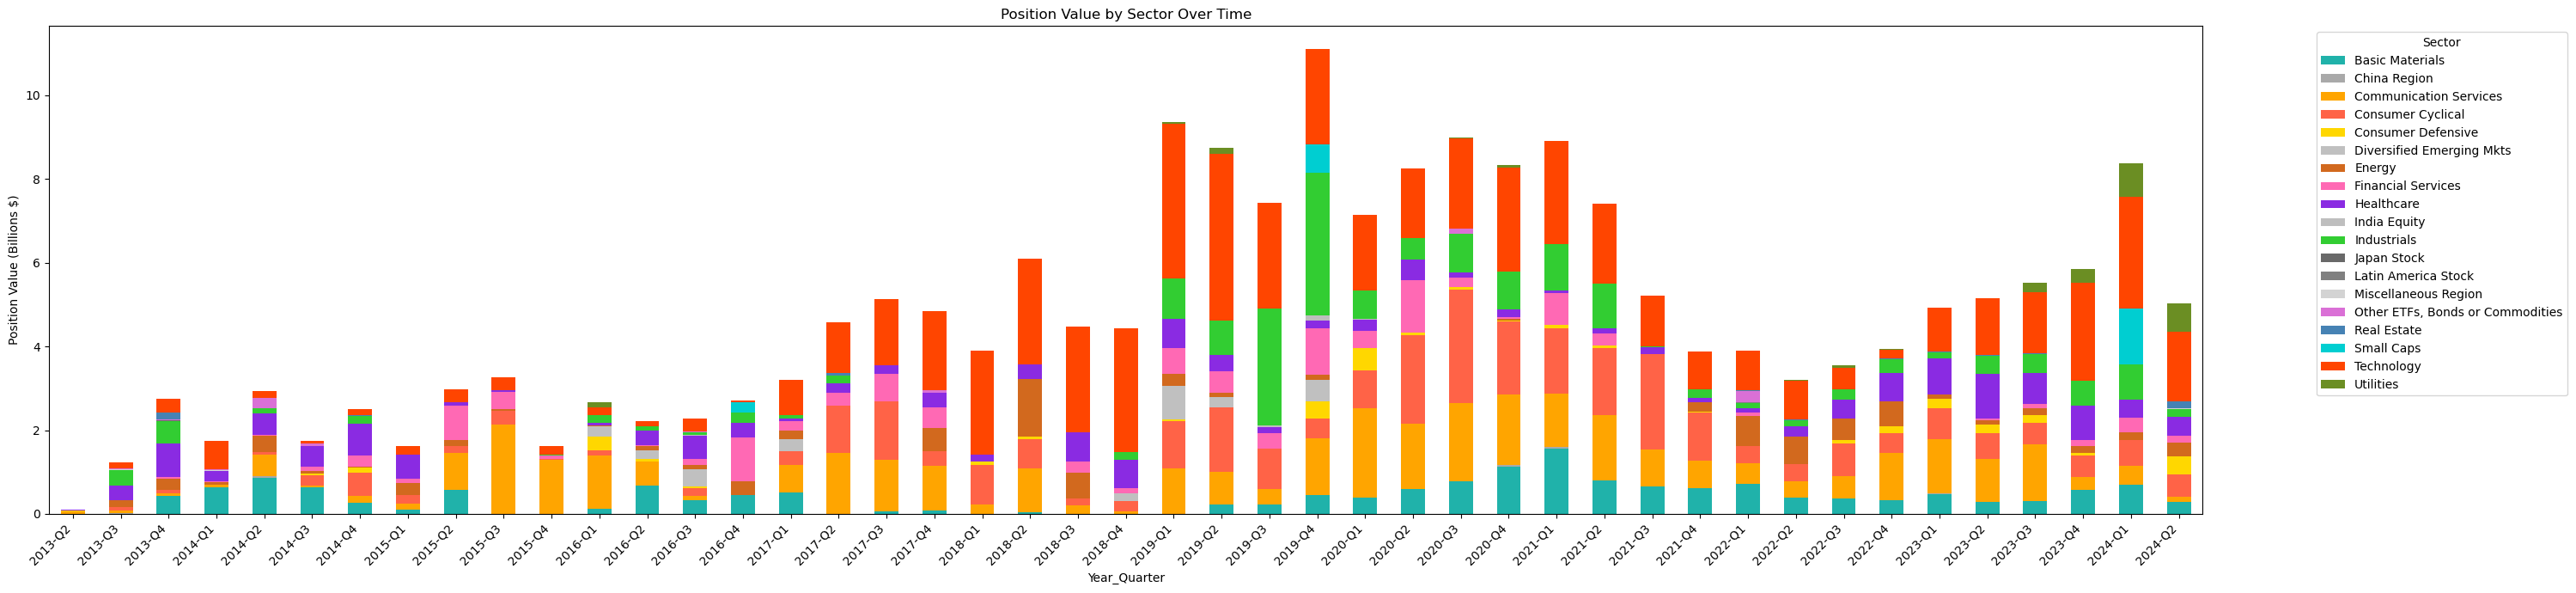

In [ ]:
# Assuming holdings_data["Stanley_Druckenmiller"] is already loaded as a DataFrame
df = holdings_data["Stanley_Druckenmiller"].groupby(["Year_Quarter", "Sector_Simp"])["Position Value"].sum().reset_index()

# Pivot the table to get sectors as columns
pivot_df = df.pivot(index='Year_Quarter', columns='Sector_Simp', values='Position Value').fillna(0)

# Create a color map with distinct colors
colors = [sector_colors.get(sector, 'gray') for sector in pivot_df.columns]

# Plot the stacked bar chart with distinct colors
pivot_df.plot(kind='bar', stacked=True, figsize=(30, 7), color=colors)

plt.title('Position Value by Sector Over Time')
plt.xlabel('Year_Quarter')
plt.ylabel('Position Value (Billions $)')
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')

def billions_formatter(x, pos):
    return f"{x // 1e9:.0f}"
plt.gca().yaxis.set_major_formatter(FuncFormatter(billions_formatter))


plt.tight_layout()
plt.show()

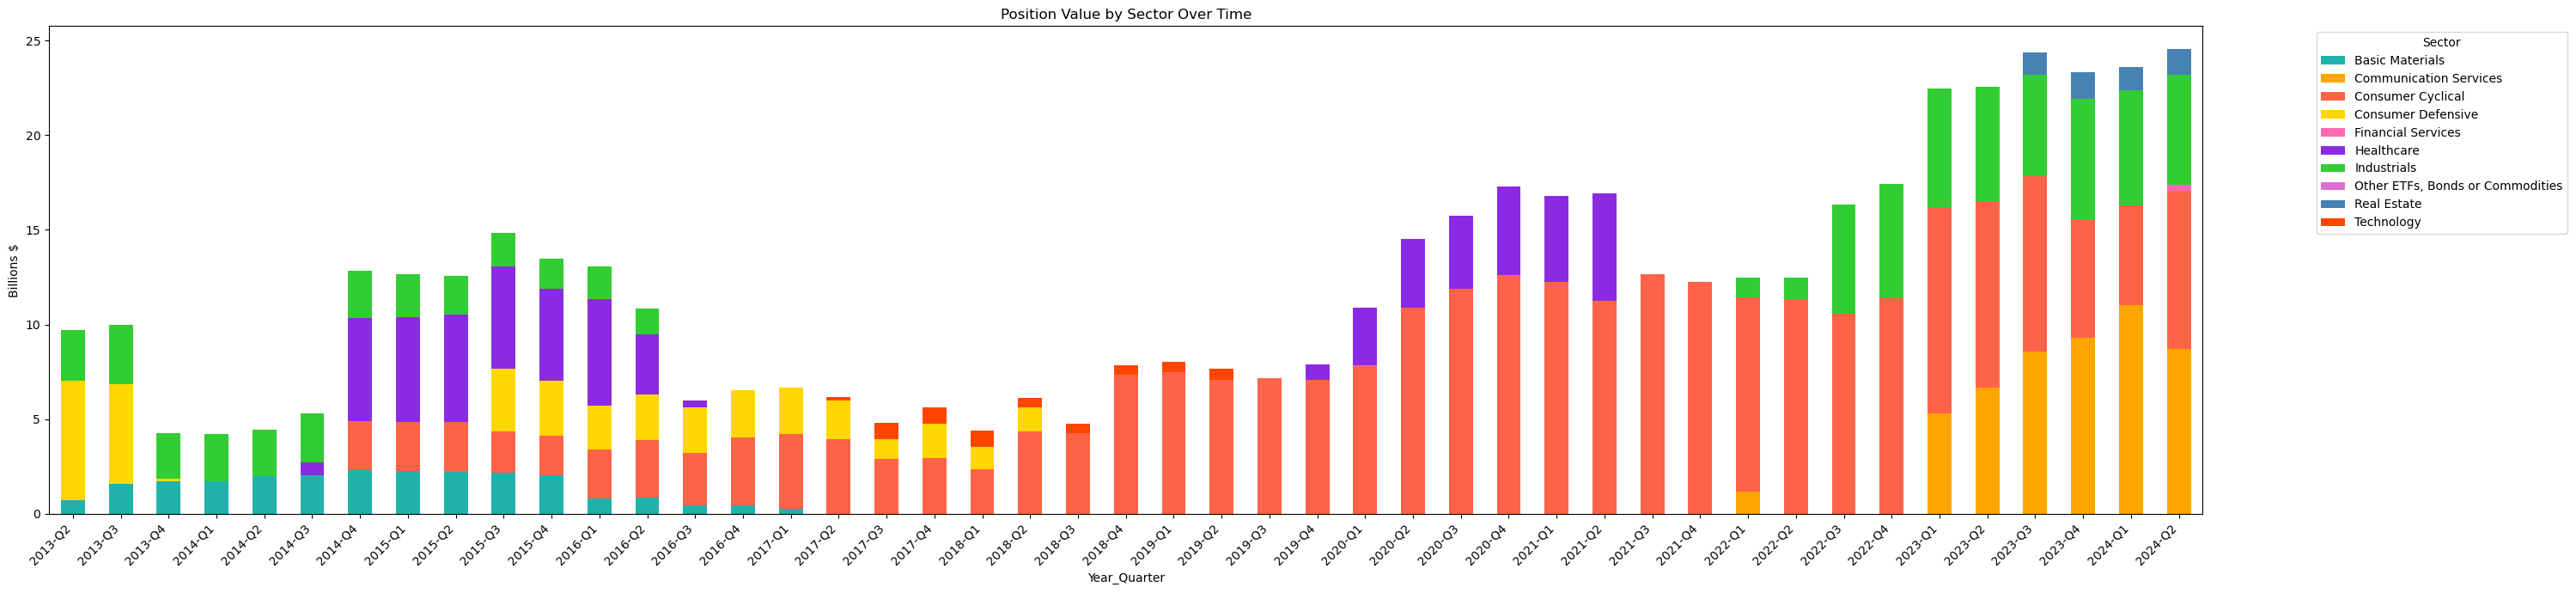

In [ ]:
# Assuming holdings_data["Stanley_Druckenmiller"] is already loaded as a DataFrame
df = holdings_data["Bill_Ackman"].groupby(["Year_Quarter", "Sector_Simp"])["Position Value"].sum().reset_index()

# Pivot the table to get sectors as columns
pivot_df = df.pivot(index='Year_Quarter', columns='Sector_Simp', values='Position Value').fillna(0)

# Create a color map with distinct colors
colors = [sector_colors.get(sector, 'gray') for sector in pivot_df.columns]

# Plot the stacked bar chart with distinct colors
pivot_df.plot(kind='bar', stacked=True, figsize=(30, 7), color=colors)

plt.title('Position Value by Sector Over Time')
plt.xlabel('Year_Quarter')
plt.ylabel('Billions $')
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')

def billions_formatter(x, pos):
    return f"{x // 1e9:.0f}"
plt.gca().yaxis.set_major_formatter(FuncFormatter(billions_formatter))

plt.tight_layout()
plt.show()

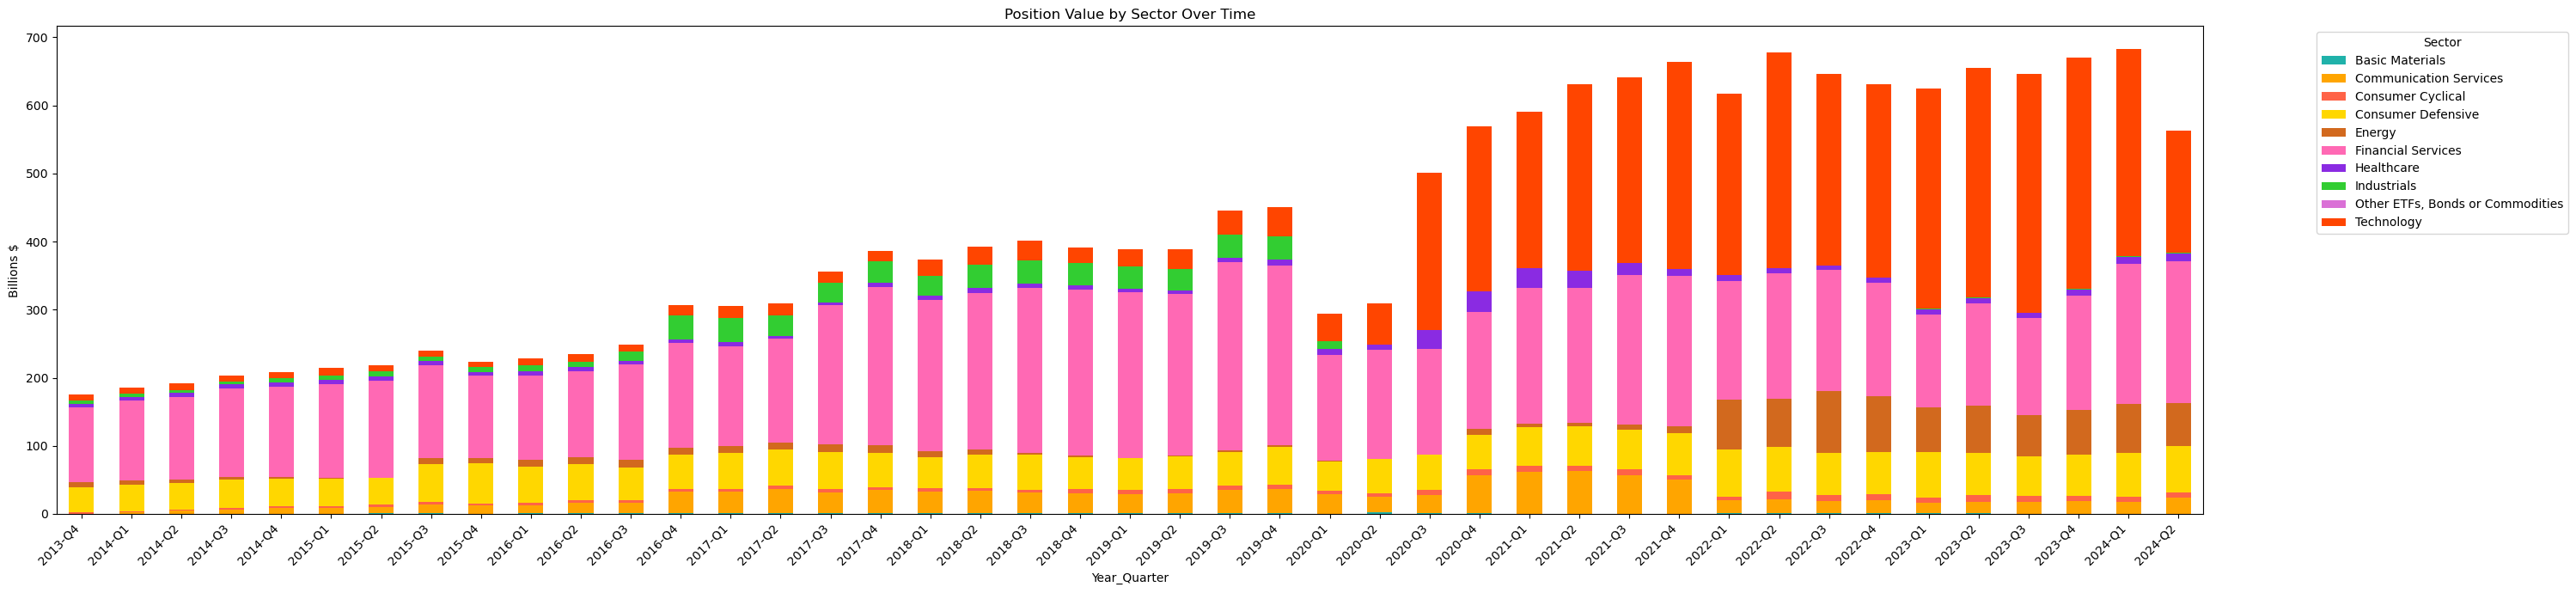

In [ ]:

# Assuming holdings_data["Stanley_Druckenmiller"] is already loaded as a DataFrame
df = holdings_data["Warren_Buffet"].groupby(["Year_Quarter", "Sector_Simp"])["Position Value"].sum().reset_index()

# Pivot the table to get sectors as columns
pivot_df = df.pivot(index='Year_Quarter', columns='Sector_Simp', values='Position Value').fillna(0)

# Create a color map with distinct colors
# Create a color map with distinct colors
colors = [sector_colors.get(sector, 'gray') for sector in pivot_df.columns]

# Plot the stacked bar chart with distinct colors
pivot_df.plot(kind='bar', stacked=True, figsize=(30, 7), color=colors)

plt.title('Position Value by Sector Over Time')
plt.xlabel('Year_Quarter')
plt.ylabel('Billions $')
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')

def billions_formatter(x, pos):
    return f"{x // 1e9:.0f}"
plt.gca().yaxis.set_major_formatter(FuncFormatter(billions_formatter))

plt.tight_layout()
plt.show()

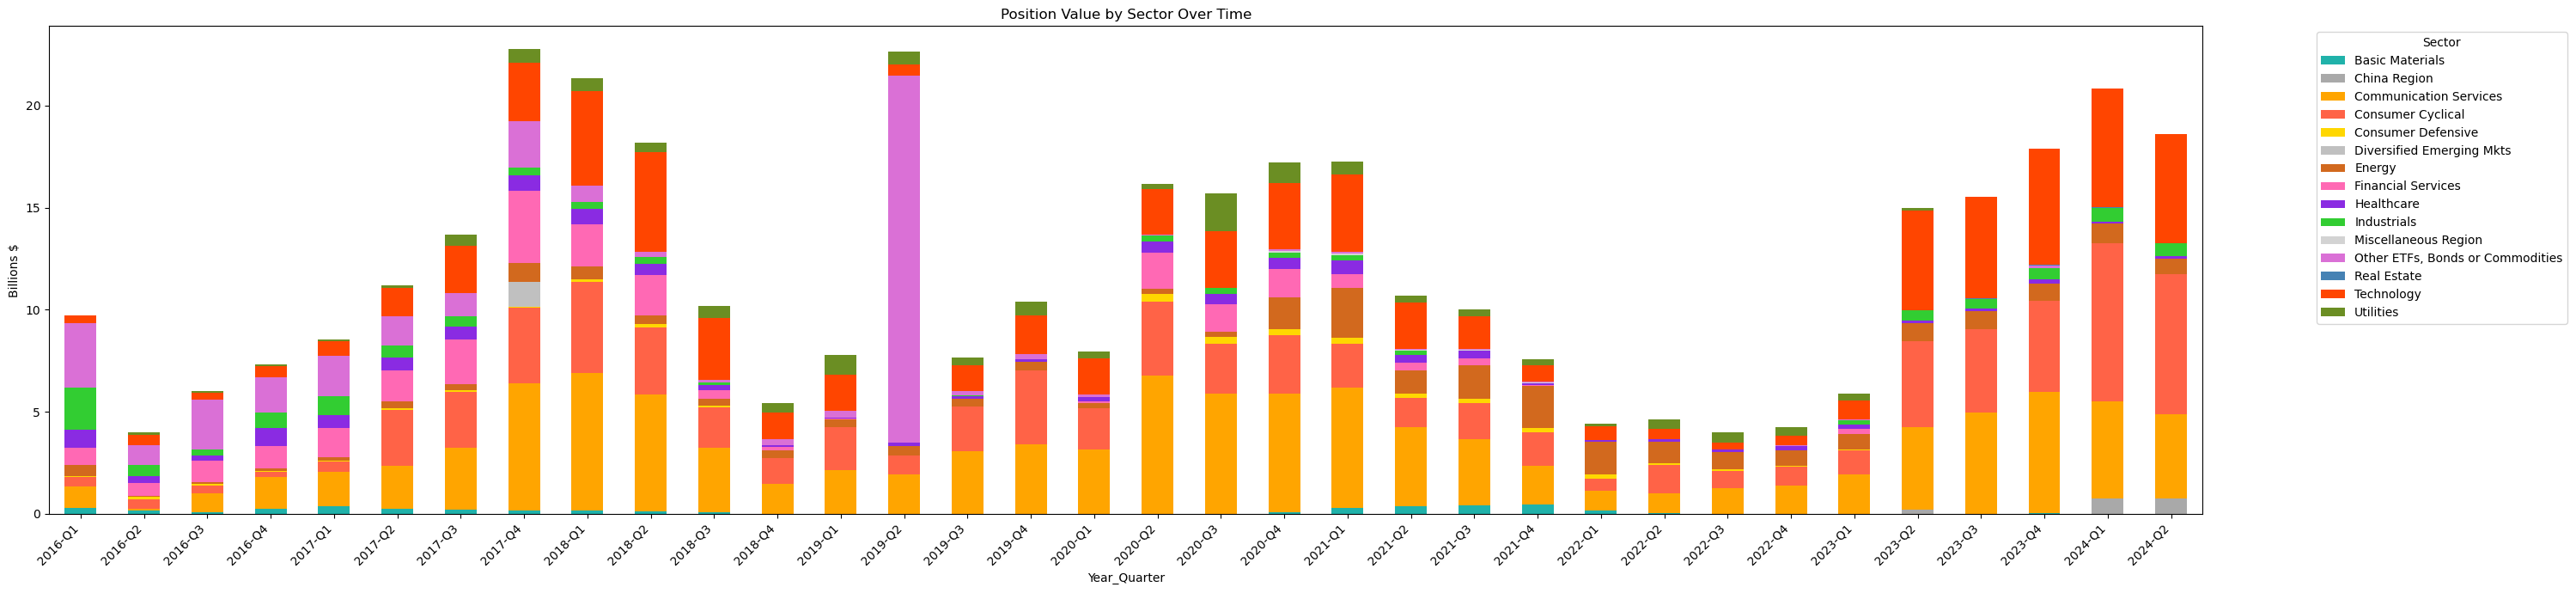

In [ ]:

# Assuming holdings_data["Stanley_Druckenmiller"] is already loaded as a DataFrame
df = holdings_data["David_Tepper"].groupby(["Year_Quarter", "Sector_Simp"])["Position Value"].sum().reset_index()

# Pivot the table to get sectors as columns
pivot_df = df.pivot(index='Year_Quarter', columns='Sector_Simp', values='Position Value').fillna(0)

# Create a color map with distinct colors
# Create a color map with distinct colors
colors = [sector_colors.get(sector, 'gray') for sector in pivot_df.columns]

# Plot the stacked bar chart with distinct colors
pivot_df.plot(kind='bar', stacked=True, figsize=(30, 7), color=colors)

plt.title('Position Value by Sector Over Time')
plt.xlabel('Year_Quarter')
plt.ylabel('Billions $')
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')

def billions_formatter(x, pos):
    return f"{x // 1e9:.0f}"
plt.gca().yaxis.set_major_formatter(FuncFormatter(billions_formatter))

plt.tight_layout()
plt.show()

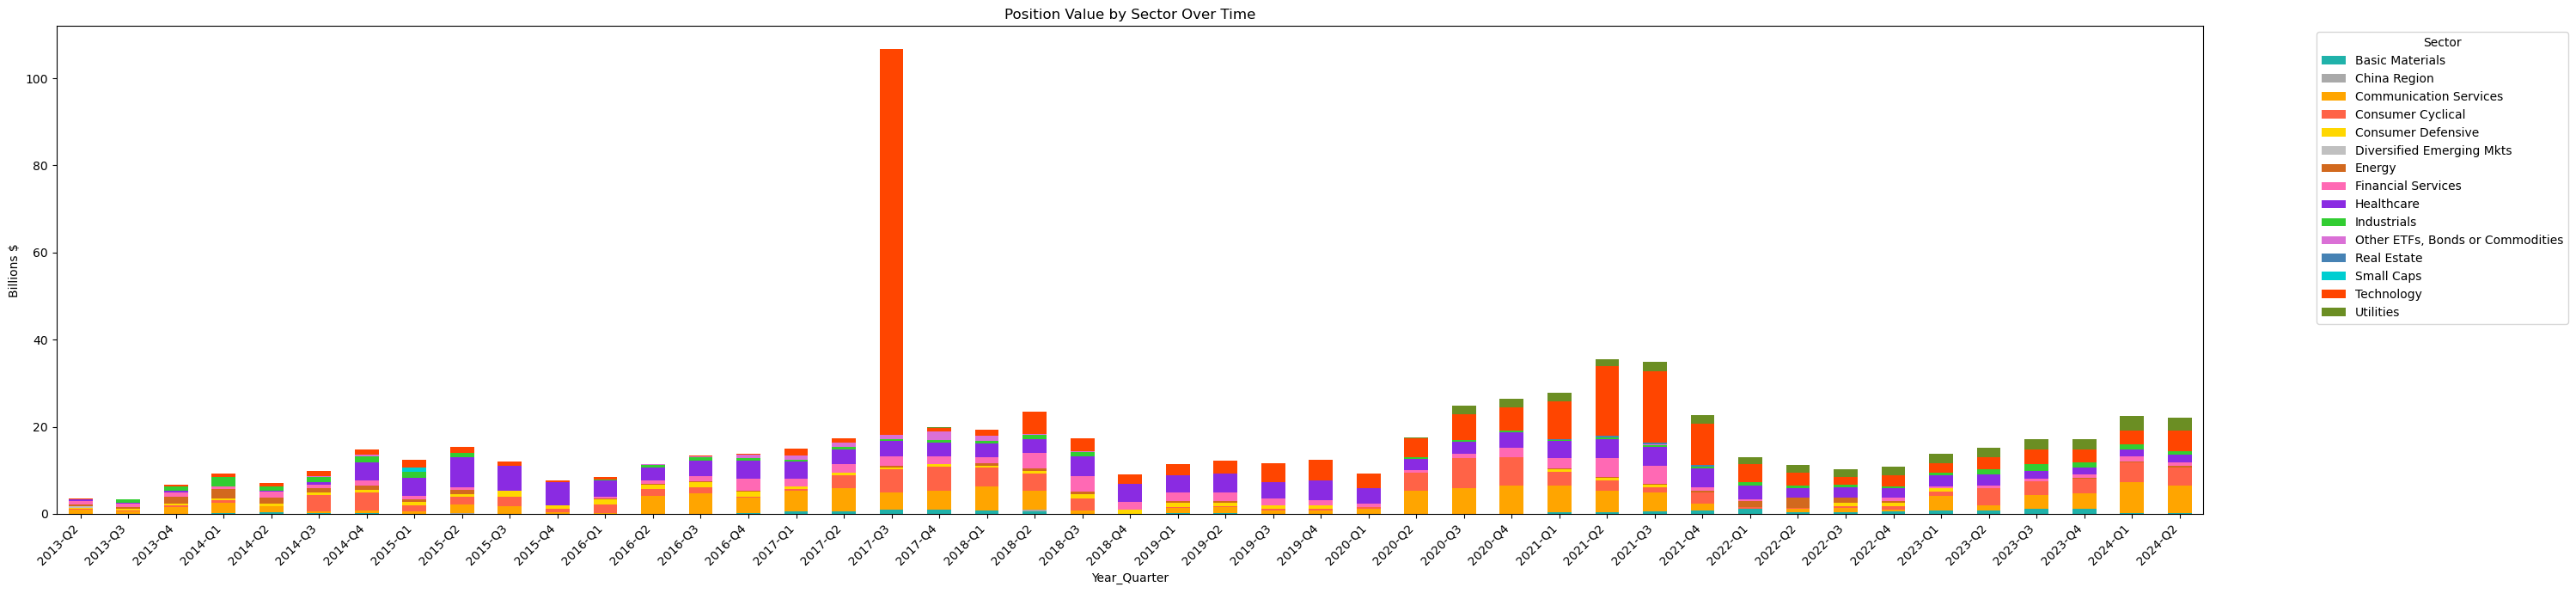

In [ ]:

# Assuming holdings_data["Stanley_Druckenmiller"] is already loaded as a DataFrame
df = holdings_data["Daniel_Loeb"].groupby(["Year_Quarter", "Sector_Simp"])["Position Value"].sum().reset_index()

# Pivot the table to get sectors as columns
pivot_df = df.pivot(index='Year_Quarter', columns='Sector_Simp', values='Position Value').fillna(0)

# Create a color map with distinct colors
# Create a color map with distinct colors
colors = [sector_colors.get(sector, 'gray') for sector in pivot_df.columns]

# Plot the stacked bar chart with distinct colors
pivot_df.plot(kind='bar', stacked=True, figsize=(30, 7), color=colors)

plt.title('Position Value by Sector Over Time')
plt.xlabel('Year_Quarter')
plt.ylabel('Billions $')
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')

def billions_formatter(x, pos):
    return f"{x // 1e9:.0f}"
plt.gca().yaxis.set_major_formatter(FuncFormatter(billions_formatter))

plt.tight_layout()
plt.show()

In [ ]:
returns

,Year_Quarter,NextDay,QuarterEnd,Starting Value,Ending Value,spy_start,spy_end,Quarterly Return,Benchmark Return,Return Ann Roll4,Benchmark Return Ann Roll4,Total Return,Benchmark Total Return,Alpha
0,2013-Q3,2013-08-15,2013-11-15,3.054429e+07,3.465951e+07,167.410004,179.559998,0.134729,0.072576,NaN,NaN,1.134729,1.072576,NaN
1,2013-Q4,2013-11-15,2014-02-18,5.483022e+08,6.235188e+08,179.559998,184.179993,0.137181,0.025730,NaN,NaN,1.290393,1.100173,NaN
2,2014-Q1,2014-02-18,2014-05-15,1.093335e+09,1.132097e+09,184.179993,188.679993,0.035453,0.024433,NaN,NaN,1.336141,1.127053,NaN
3,2014-Q2,2014-05-15,2014-08-15,5.530693e+08,6.224545e+08,188.679993,196.470001,0.125455,0.041287,1.503766,1.173586,1.503766,1.173586,0.330180
4,2014-Q3,2014-08-15,2014-11-17,1.061547e+09,1.025732e+09,196.470001,203.850006,-0.033739,0.037563,1.280509,1.135275,1.453031,1.217669,0.145234
5,2014-Q4,2014-11-17,2015-02-13,6.591472e+08,6.828494e+08,203.850006,209.070007,0.035959,0.025607,1.166529,1.135140,1.505280,1.248850,0.031389
6,2015-Q1,2015-02-13,2015-05-18,9.454945e+08,9.548894e+08,209.070007,212.240005,0.009937,0.015162,1.137782,1.124868,1.520238,1.267786,0.012915
7,2015-Q2,2015-05-18,2015-08-17,6.508286e+08,6.207385e+08,212.240005,208.710007,-0.046233,-0.016632,0.964214,1.062300,1.449952,1.246700,-0.098086
8,2015-Q3,2015-08-17,2015-11-16,9.827349e+08,9.579497e+08,208.710007,202.320007,-0.025221,-0.030617,0.972714,0.992494,1.413383,1.208530,-0.019781
9,2015-Q4,2015-11-16,2016-02-17,7.854509e+08,7.413598e+08,202.320007,191.160004,-0.056135,-0.055160,0.886242,0.914335,1.334043,1.141867,-0.028093


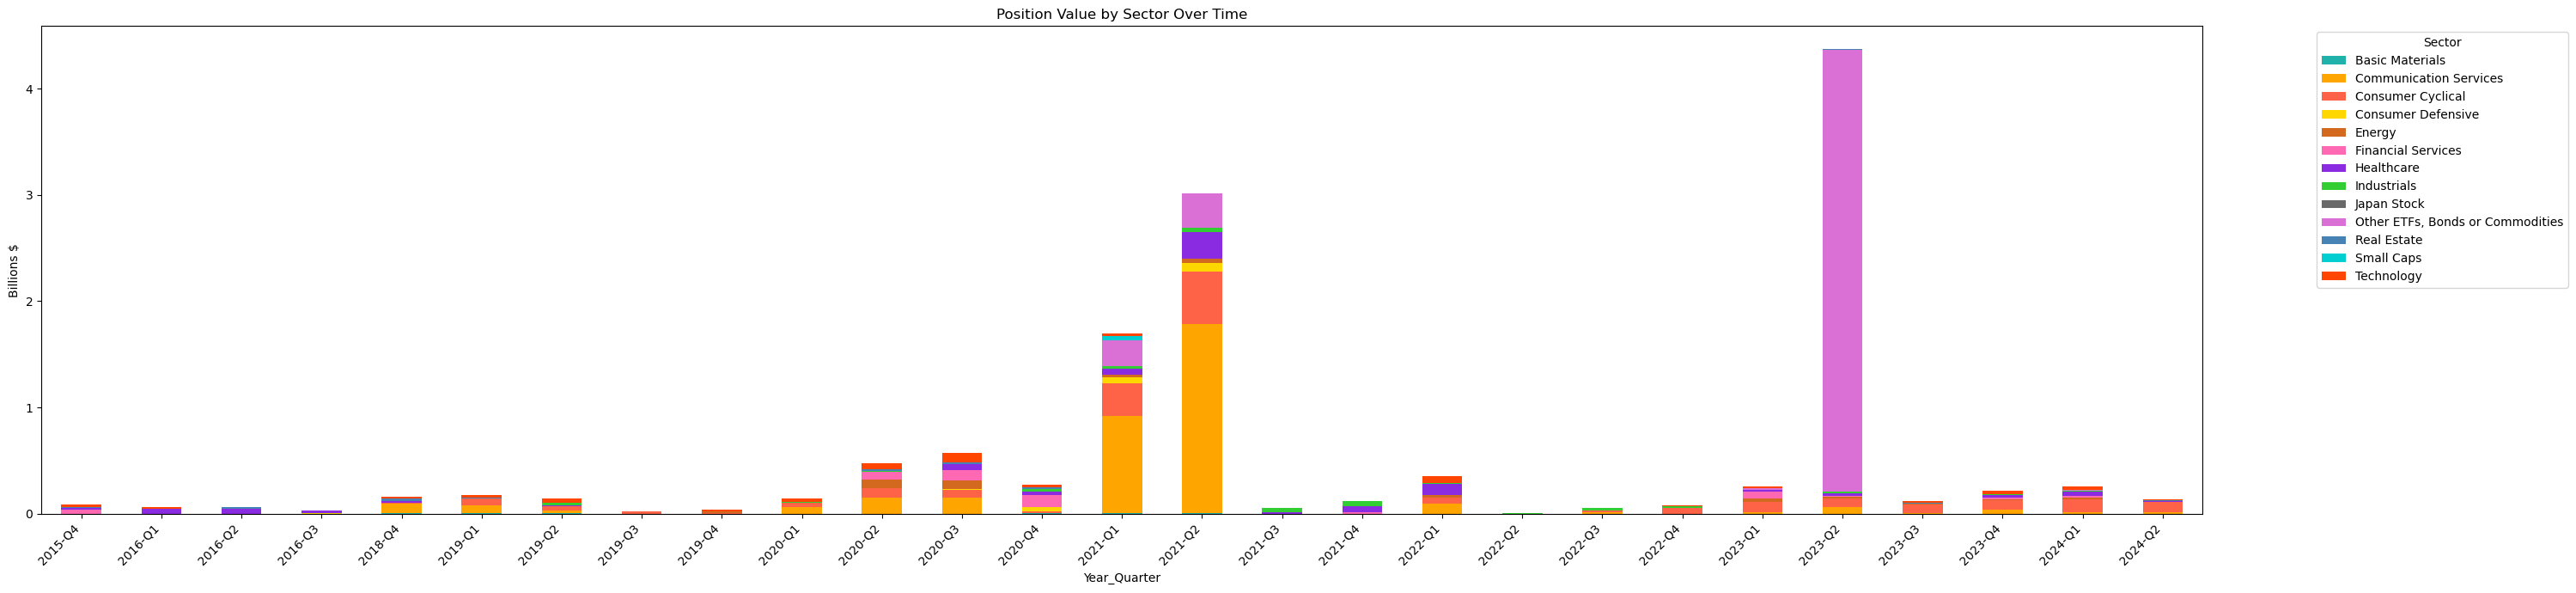

In [ ]:

# Assuming holdings_data["Stanley_Druckenmiller"] is already loaded as a DataFrame
df = holdings_data["Michael_Burray"].groupby(["Year_Quarter", "Sector_Simp"])["Position Value"].sum().reset_index()

# Pivot the table to get sectors as columns
pivot_df = df.pivot(index='Year_Quarter', columns='Sector_Simp', values='Position Value').fillna(0)

# Create a color map with distinct colors
# Create a color map with distinct colors
colors = [sector_colors.get(sector, 'gray') for sector in pivot_df.columns]

# Plot the stacked bar chart with distinct colors
pivot_df.plot(kind='bar', stacked=True, figsize=(30, 7), color=colors)

plt.title('Position Value by Sector Over Time')
plt.xlabel('Year_Quarter')
plt.ylabel('Billions $')
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')

def billions_formatter(x, pos):
    return f"{x // 1e9:.0f}"
plt.gca().yaxis.set_major_formatter(FuncFormatter(billions_formatter))

plt.tight_layout()
plt.show()

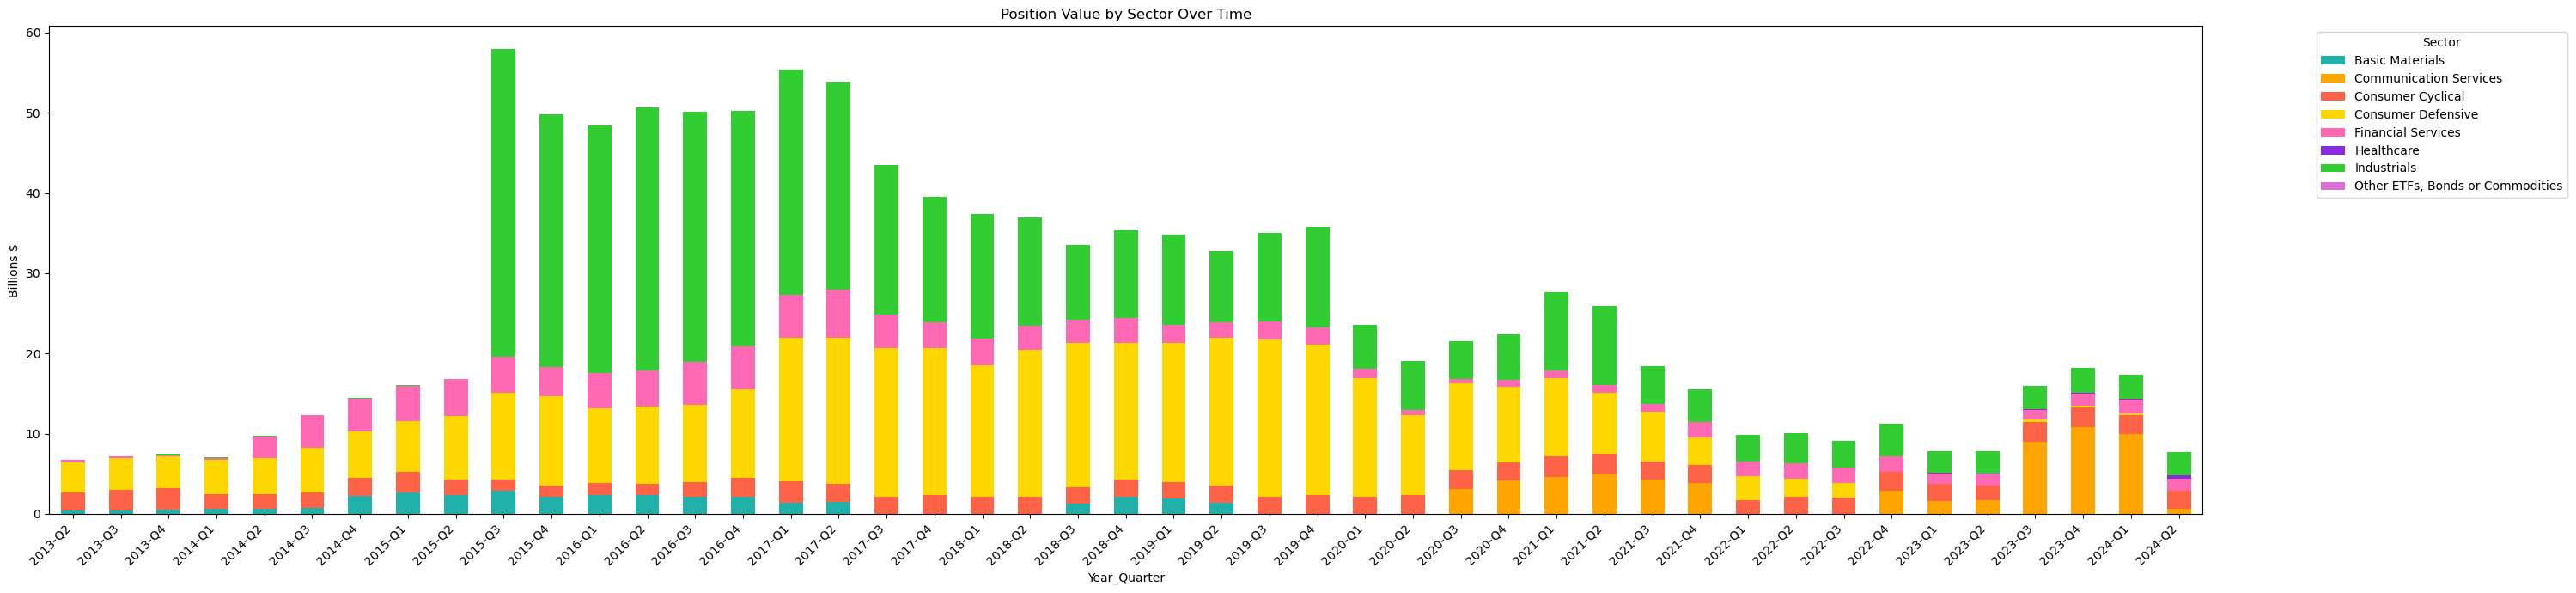

In [ ]:

# Assuming holdings_data["Stanley_Druckenmiller"] is already loaded as a DataFrame
df = holdings_data["Nelson_Peltz"].groupby(["Year_Quarter", "Sector_Simp"])["Position Value"].sum().reset_index()

# Pivot the table to get sectors as columns
pivot_df = df.pivot(index='Year_Quarter', columns='Sector_Simp', values='Position Value').fillna(0)

# Create a color map with distinct colors
# Create a color map with distinct colors
colors = [sector_colors.get(sector, 'gray') for sector in pivot_df.columns]

# Plot the stacked bar chart with distinct colors
pivot_df.plot(kind='bar', stacked=True, figsize=(30, 7), color=colors)

plt.title('Position Value by Sector Over Time')
plt.xlabel('Year_Quarter')
plt.ylabel('Billions $')
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')

def billions_formatter(x, pos):
    return f"{x // 1e9:.0f}"
plt.gca().yaxis.set_major_formatter(FuncFormatter(billions_formatter))

plt.tight_layout()
plt.show()